<a href="https://colab.research.google.com/github/harish-v07/FoodRecommendationSystem/blob/main/foodcalorie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzvf food-101.tar.gz

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/

In [ ]:
# Check the extracted dataset folder
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [ ]:
os.listdir('food-101/images')

['french_fries',
 'chicken_wings',
 'panna_cotta',
 'baklava',
 'samosa',
 'pancakes',
 'fried_calamari',
 'miso_soup',
 'gyoza',
 'edamame',
 'chocolate_cake',
 'waffles',
 'bruschetta',
 'carrot_cake',
 'bibimbap',
 'lasagna',
 'creme_brulee',
 'club_sandwich',
 'fried_rice',
 'scallops',
 'chocolate_mousse',
 'hot_and_sour_soup',
 'french_onion_soup',
 'foie_gras',
 'spaghetti_carbonara',
 'cup_cakes',
 'beef_tartare',
 'pork_chop',
 'strawberry_shortcake',
 'clam_chowder',
 'paella',
 'pulled_pork_sandwich',
 'deviled_eggs',
 'croque_madame',
 'macarons',
 'mussels',
 'hamburger',
 'nachos',
 'eggs_benedict',
 'sushi',
 'shrimp_and_grits',
 'omelette',
 'bread_pudding',
 'grilled_salmon',
 'risotto',
 'filet_mignon',
 'huevos_rancheros',
 'apple_pie',
 'oysters',
 'grilled_cheese_sandwich',
 'sashimi',
 'dumplings',
 'donuts',
 'ceviche',
 'hummus',
 'french_toast',
 'ice_cream',
 'falafel',
 'gnocchi',
 'beef_carpaccio',
 'breakfast_burrito',
 'garlic_bread',
 'tiramisu',
 'chicke

In [ ]:
os.listdir('food-101/meta')

['train.txt',
 'classes.txt',
 'train.json',
 'test.txt',
 'labels.txt',
 'test.json']

In [ ]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [ ]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


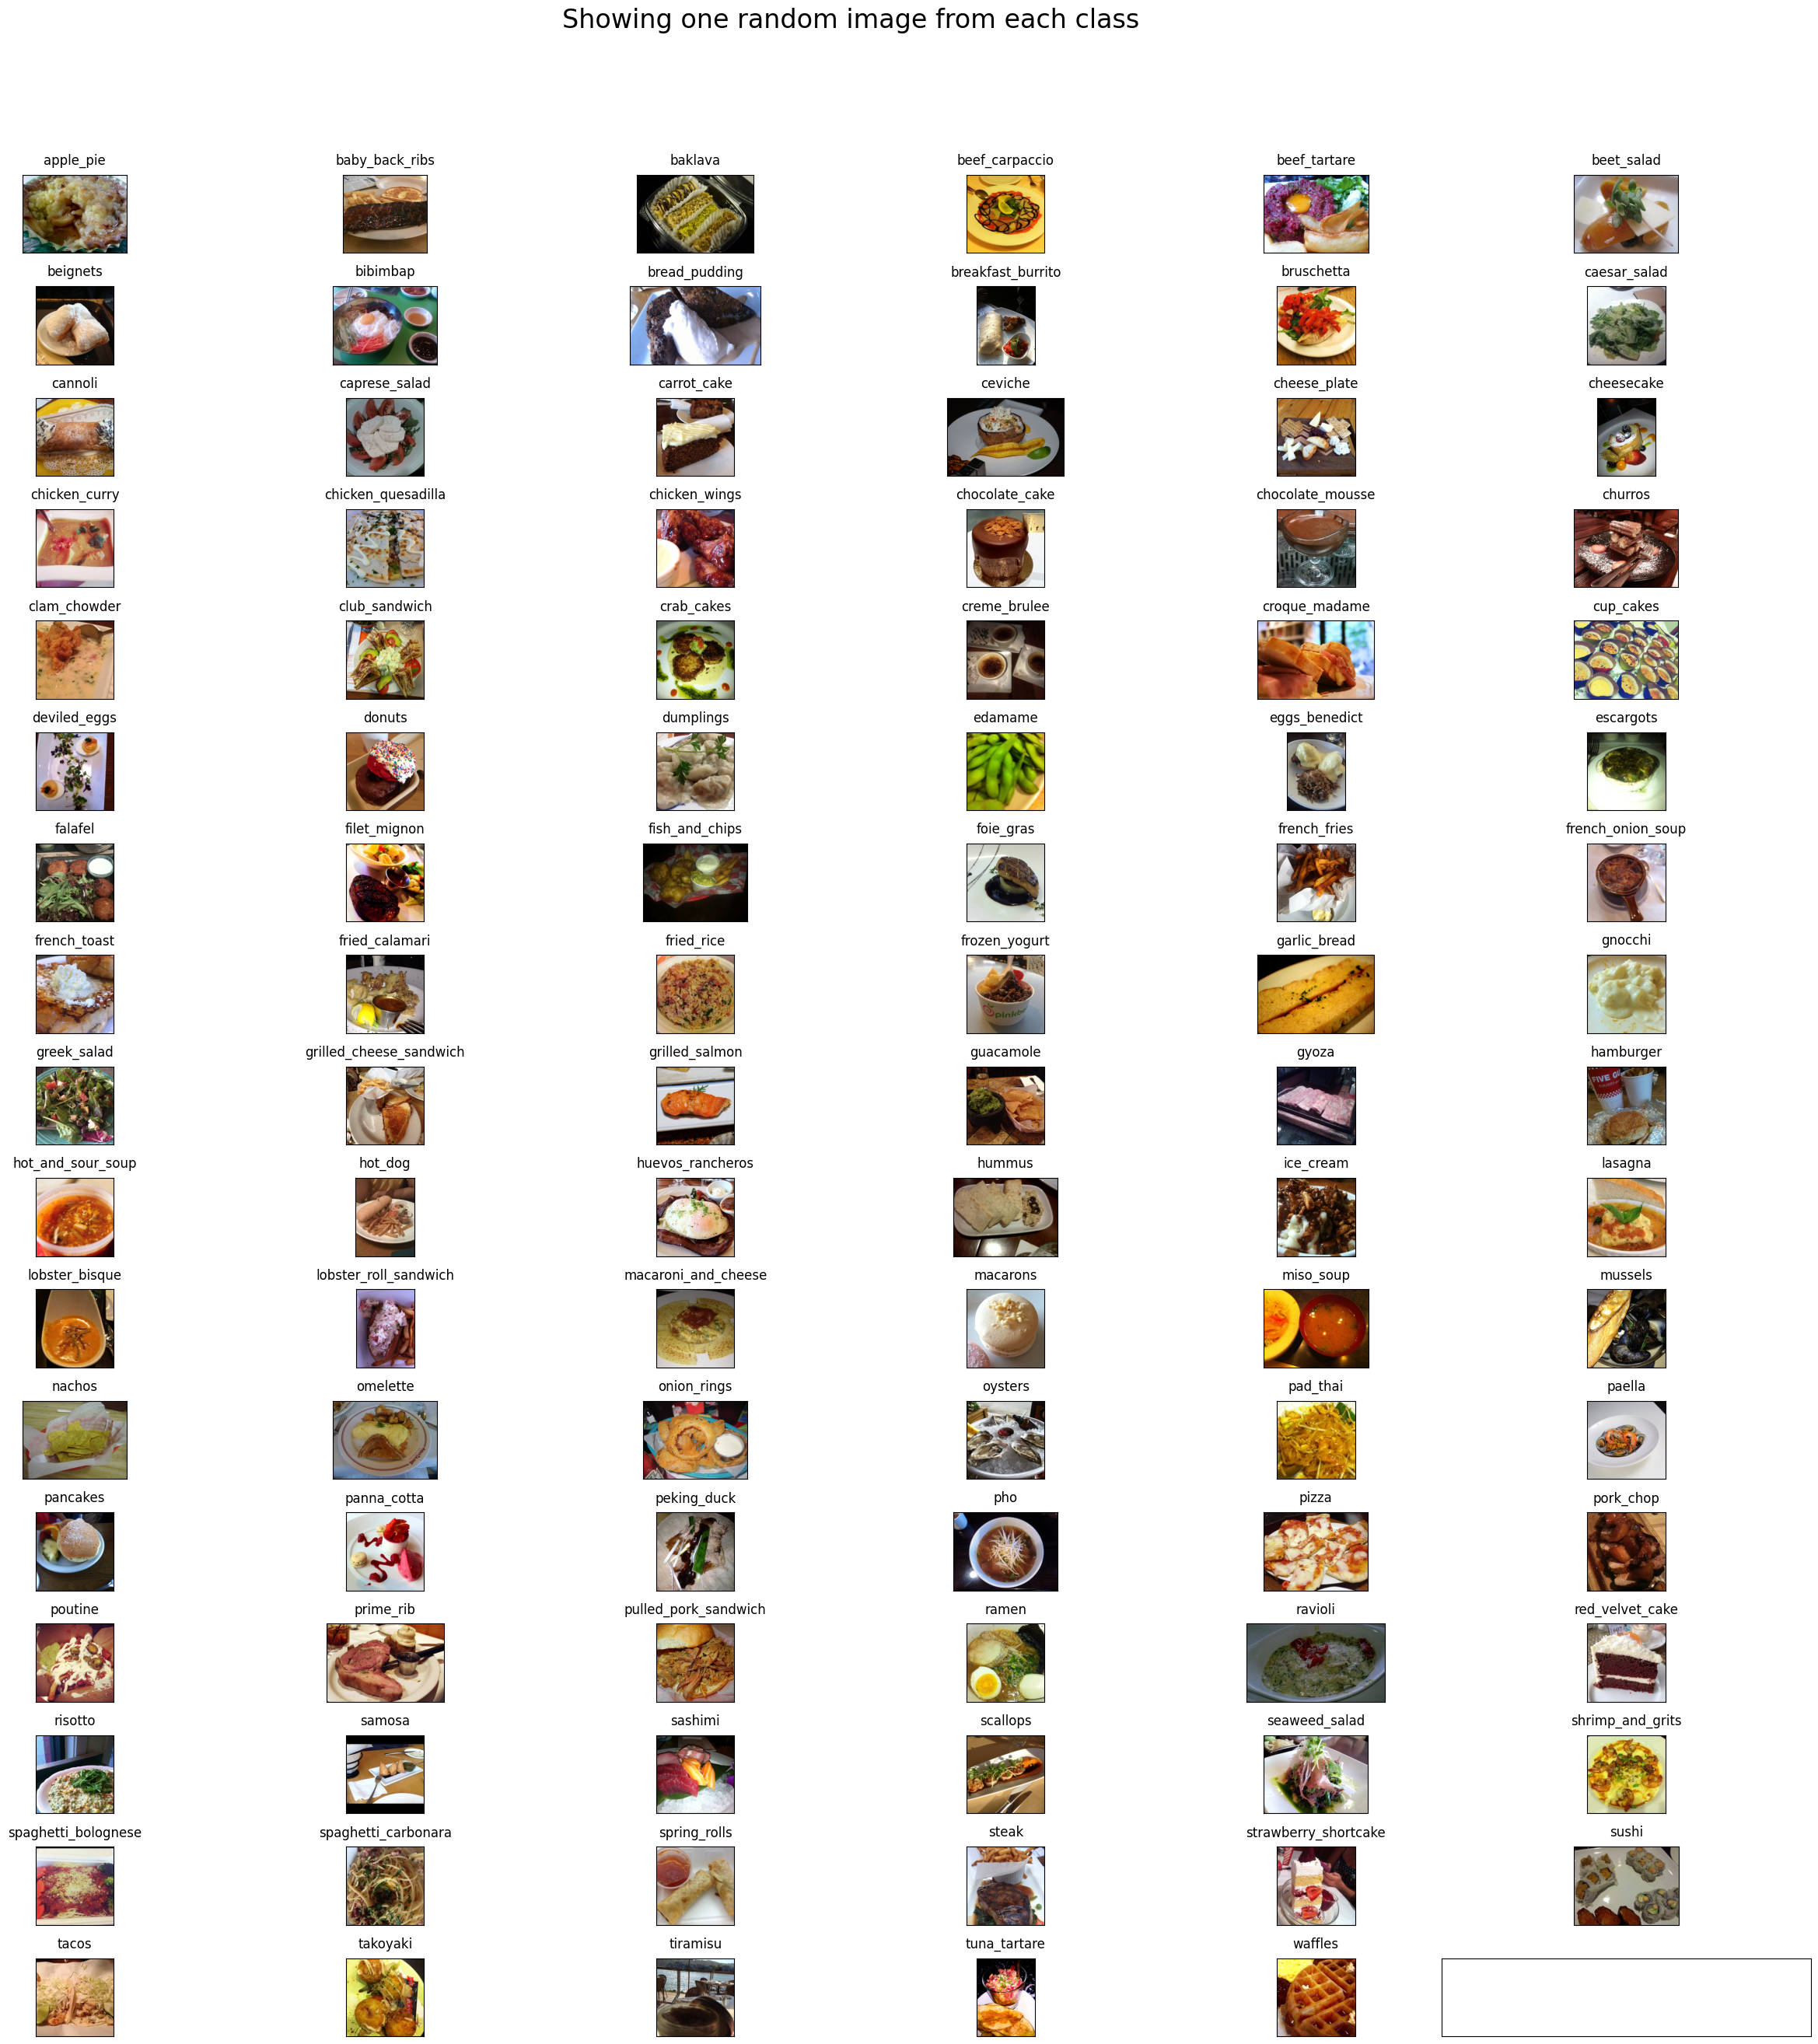

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
25250


In [ ]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
os.chdir('/')

In [ ]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [ ]:
foods_sorted

['baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))


In [ ]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = '/kaggle/working/train_mini'
src_test = 'test'
dest_test = '/kaggle/working/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in train folder")

!find /kaggle/working/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
750


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in test folder")
!find /kaggle/working/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

# Clear any previous session
K.clear_session()

# Parameters
n_classes = 3
img_width, img_height = 224, 224
train_data_dir = '/kaggle/working/train_mini'
validation_data_dir = '/kaggle/working/test_mini'
nb_train_samples = 2250
nb_validation_samples = 750
batch_size = 16

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load ResNet50 model without top layer
resnet50 = ResNet50(weights='imagenet', include_top=False)

# Add custom layers
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# Final output layer with 3 classes
predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

# Compile model
model = Model(inputs=resnet50.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpointer = ModelCheckpoint(filepath='/kaggle/working/best_model_3class.keras', verbose=1, save_best_only=True)
csv_logger = CSVLogger('/kaggle/working/history_3class.log')

# Load saved model checkpoint
model = load_model('/kaggle/working/best_model_3class.keras')

# Continue training from where it left off
# Set initial_epoch to 30 (or however many epochs you have already trained)
initial_epoch = 30
additional_epochs = 0  # Set how many more epochs to train

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=initial_epoch + additional_epochs,  # Total epochs (previous + additional)
    initial_epoch=initial_epoch,  # Resume from epoch 30
    verbose=1,
    callbacks=[csv_logger, checkpointer]
)

# Save the trained model
model.save('/kaggle/working/model_trained_3class.hdf5')

Found 750 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2

# Loading the best saved model to make predictions.
tf.keras.backend.clear_session()
model_best = load_model('/food_calorie_model.h5', compile=False)

# List of image URLs to download
image_urls = {
    'frenchfries': 'https://www.corriecooks.com/wp-content/uploads/2018/08/Instant-Pot-French-Fries.jpg'
}



/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


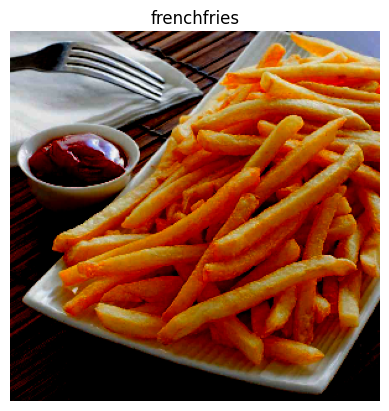

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_class(model, images, foods_sorted, show=True):
    for img_path in images:
        try:
            # Load and preprocess the image for InceptionV3
            img = image.load_img(img_path, target_size=(299, 299))  # Resize to (299, 299) for InceptionV3
            img = image.img_to_array(img)  # Convert image to a numpy array
            img = np.expand_dims(img, axis=0)  # Add batch dimension
            img = preprocess_input(img)  # Preprocess image for InceptionV3 (normalization)

            # Predict the class using the pre-trained model
            pred = model.predict(img)
            index = np.argmax(pred)  # Get the index of the highest predicted value

            # Ensure proper handling of class index
            # If foods_sorted doesn't match the order the model was trained on, you should map the prediction back
            pred_value = foods_sorted[index]  # Get the class label from the sorted list of labels

            if show:
                # Display the image with the prediction
                plt.imshow(img[0])  # Display the image
                plt.axis('off')  # Hide axes
                plt.title(pred_value)  # Set the title as the predicted class label
                plt.show()

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# List of image paths to predict
images = ['frenchfries.jpg']

# Define your sorted class labels (this should be the class labels your model was trained on)
# Ensure these are in the same order the model was trained with
foods_sorted = ['frenchfries']

# Assuming you're using a pre-trained InceptionV3 model without the top classification layers:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add global average pooling to match the expected input shape for your classifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(foods_sorted), activation='softmax')(x)

model_best = Model(inputs=base_model.input, outputs=predictions)

# Optionally load your trained model weights
# model_best.load_weights('your_model_weights.h5')

# Call the function to predict
predict_class(model_best, images, foods_sorted, True)
